# Flare Frequency Distributions, power laws, and more

## This notebook illustrates the use of the FFD module `ffd.py`. 

FFD stands for Flare Frequency Distribution. The format of the flare table that is used to inititalize an FFD object shares some of the columns of the `FlareLightCurve.flares` table. 

## This module includes functionality to 

- fit the power law exponent $\alpha$ and intercept $\beta$, 
- plot the resulting function in the cumulative form,
- test if the power law assumption must be rejected, 
- and if the distribution is truncated at the high energy end.

Furthermore, you can make use of the `ed_corr`, `recovery_probability` attributes of the flares in the flare table that you may obtain from performing *injection and recovery of synthetic flares*.

Finally, if your flare table contains contributions from multiple stars that you think generate flares that can be described by the same power law but with different detection thresholds, you can use the `mutliple_stars` keyword to account for this. 

*Note that samples with less than 100-200 flares are to be analysed with caution.*

In [1]:
# Import the main class and a function to generate synthetic flare samples.
from altaipony.ffd import FFD, generate_random_power_law_distribution

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 16

## Correct for energy ratio, recovery probability, and detection thresholds

Let's now generate a sample of flares that stem from different stars with different detection thresholds. They shall also have some observational bias captured by the corrected $ED$ `ed_corr` and recovery probability. We choose them to be the same for all stars for simplicity.

In [2]:
# energy lower and upper limit, power law exponent +1, number of flares
a0, b, g, size = 10, 1e8, -1, 30
df = pd.DataFrame()

for a in [60, 100, 8, 90, 16, 220, 110, 50, 22, 80]: # random minimum detected flare energy
    # all flares stem from the same power law distribution
    pwls = generate_random_power_law_distribution(a0, b, g, size=size)
    # apply minimum detected flare energy
    pwls = pwls[pwls > a]
    df = df.append(pd.DataFrame({
                                # power law distributed detected flare energies
                                "ed_rec": pwls,
                                # true flare energies are typically larger than the detected ones
                                "ed_corr": pwls * 2.,
                                #maximum recovery probability is 1, otherwise 0-1
                                "recovery_probability": .7,
                                #different targets have different detection thresholds
                                "TIC": a,
                                }))
    
# Init a FFD with total observing time 5. (units of your choice),
# column name of the star ID is "TIC"
multi_ffd = FFD(f=df, ID="TIC", tot_obs_time=5.)

# Show table
multi_ffd.f.head()

,ed_rec,ed_corr,recovery_probability,TIC
0,103.789481,207.578963,0.7,60
1,301.102159,602.204317,0.7,60
2,518.324786,1036.649573,0.7,60
0,137.326262,274.652525,0.7,100
0,22.455077,44.910155,0.7,8


#### Plot the distributions using the different correction steps:

1. No correction. Just `ed_rec` vs. frequency

2. Correct the ED ratio between injected and recovered flares, i.e., use the `ed_corr` column and the frequency. 
   This is done by setting `energy_correction = True`
    
3. Now use `ed_corr` and correct the individual frequencies of each flare by `recovery_probability`. 

    This is done by adding the `recovery_probability_correction = True` keyword.
    
4. Finally, average each portion of the FFD by the number of stars that contribute to it by adding another keyword: `multiple_stars = True`

Setting ED with new values, size 82.
Setting frequency values with new values, size 82.
Setting frequency adjusted count values with new values, size 82.
Setting ED with new values, size 82.
Setting frequency values with new values, size 82.
Setting frequency adjusted count values with new values, size 82.
Setting ED with new values, size 82.
Setting frequency values with new values, size 82.
Setting frequency adjusted count values with new values, size 82.
Setting multiple_stars flag with True.
Setting ED with new values, size 82.
Setting frequency values with new values, size 82.
Setting frequency adjusted count values with new values, size 408.


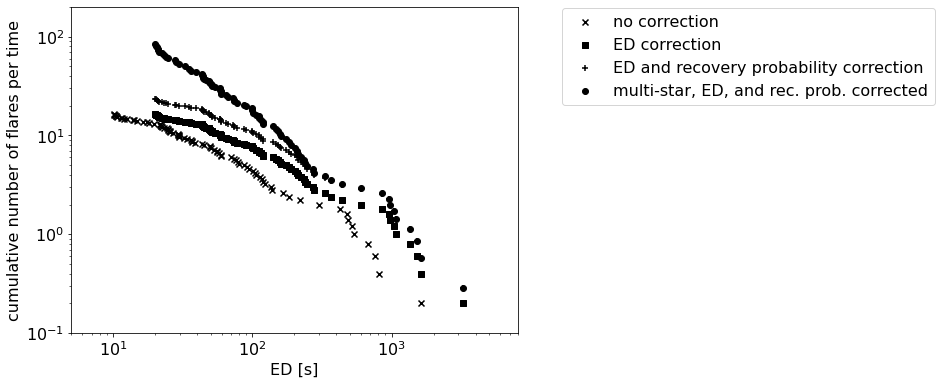

In [3]:
fig, ax = plt.subplots(1, figsize=(8,6))


ed, freq, counts = multi_ffd.ed_and_freq()

ax.scatter(ed, freq, c="k", marker="x", label="no correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True)
ax.scatter(ed, freq, c="k", marker="s", label="ED correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True,
                                         recovery_probability_correction=True)

ax.scatter(ed, freq, c="k", marker="+", label="ED and recovery probability correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True,
                                         recovery_probability_correction=True,
                                         multiple_stars=True)

ax.scatter(ed, freq, c="k", label="multi-star, ED, and rec. prob. corrected")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per time")
ax.set_xlim(5, 8e3)
ax.set_ylim(.1, 2e2)
plt.legend(loc=(1.1, .7));

### Fit $\alpha$ using the MLE method.

Let us use the quick modified MLE estimator again (see the Beginner notebook for details and why I would otherwise recommend using the MCMC method).

You can use it by passing "mmle" to `fit_powerlaw()`

In [4]:
multi_ffd.fit_powerlaw("mmle")

In [5]:
print(f"alpha = {multi_ffd.alpha:.2f} +/- {multi_ffd.alpha_err:.2f}")
print(f"beta = {multi_ffd.beta:.0f} +/- {multi_ffd.beta_err:.0f}")

alpha = 2.07 +/- 0.06
beta = 2175 +/- 134


Finally, show the resulting fit, and compare to the intrinsic distribution:

Setting multiple_stars flag with True.
Setting ED with new values, size 82.
Setting frequency values with new values, size 82.
Setting frequency adjusted count values with new values, size 408.


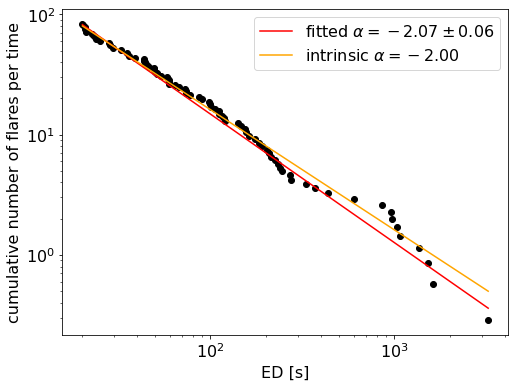

In [10]:
fig, ax = plt.subplots(1, figsize=(8,6))

# Plot the FFD together with the best fit power law

ax.scatter(multi_ffd.ed, multi_ffd.freq, c="k")
multi_ffd.plot_powerlaw(ax, c="r", 
                        label=fr"fitted $\alpha=-{multi_ffd.alpha:.2f} \pm {multi_ffd.alpha_err:.2f}$")

# Add the intrinsic distribution-------------------------------------------------

multi_ffd2 = FFD(f=df, ID="TIC", tot_obs_time=5.)

multi_ffd2.ed_and_freq(energy_correction=True,
                       recovery_probability_correction=True,
                       multiple_stars=True)

multi_ffd2.alpha, multi_ffd2.alpha_err = -g + 1, .1

multi_ffd2.fit_beta_to_powerlaw()

multi_ffd2.plot_powerlaw(ax, c="orange", label=fr"intrinsic $\alpha=-{multi_ffd2.alpha:.2f}$")

#--------------------------------------------------------------------------------------

plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per time")
plt.legend();

#### Let's test if the two solutions are consistent with a power law.

In [11]:
multi_ffd.is_powerlaw(), multi_ffd2.is_powerlaw()

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony/ffd.py:507: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


(True, True)

They should not be truncated because we did not cut out any of the high energy flares:

In [12]:
multi_ffd.is_powerlaw_truncated(), multi_ffd2.is_powerlaw_truncated()

(False, False)